# LightGCNPlus

### Scope
In this notebook we train different variants of our LightGCNPlus model on different hyperparameters. We then re-train the best performing model and evaluate it on Kaggle's public test set.

### About the model
LightGCNPlus is a graph-based collaborative filtering model that extends the [original LightGCN model](https://arxiv.org/pdf/2002.02126.pdf). The original LightGCN is only able to rank items. We thus refine the model to be able to predict ratings. Our LightGCNPlus model is composed of the following components:
- message passing: $e_u^{(l)} = \sum_{v \in N(u)} \frac{sr_{u,v}}{\sqrt{|N(u)||N(v)|}} e_v^{(l-1)}$, where $sr_{u,v}$ is the standardized rating of user $u$ for item $v$.
- aggregation mechanism: $h_u = \text{concat}(e_u^{(0)}, e_u^{(1)}, ..., e_u^{(L)})$, where $L$ is the number of layers in the message passing mechanism.
- output layer: $\hat{R}_{(i,j)} = \text{MLP}(\text{concat}(h_i, h_j))$, where $\text{MLP}$ is a multi-layer perceptron that projects the embedding couples of observed ratings to the output space.

How our model differs from the original LightGCN:
- In the message passing layer we use the standardized ratings instead of the raw interactions (binary in the original case).
- We use an MLP in the output layer instead of a dot product. This inspired by the [neural collaborative filtering paper](https://arxiv.org/pdf/1708.05031.pdf), in order to predict ratings instead of just ranking unobserved interactions.

### Hyperparameter tuning
The hyperparameters comprise both choices about the models' architecture and the training procedure.
We perform a grid search over the following hyperparameters:
- K: Embedding size.
- L: Number of layers in the message passing mechanism.
- PROJECTIONS: Architecture of the MLP that projects the embedding couples of observed ratings to the output space.

Other hyperparameters such as the learning rate, the batch size, the number of epochs, the optimizer, etc. have been selected based on the results on previous experiments. Thus, to reduce the computational cost of the grid search, the following hyperparameters are kept constant:
- LR: learning rate.
- INIT_EMBS_STD: standard deviation of the normal distribution used to initialize the embeddings.
- WEIGHT_DECAY: weight decay coefficient for the Adam optimizer.
- DROPOUT: dropout rate used in the MLP's hidden layers.
- ACT_FN: activation function used in the MLP's hidden layers.

We also define hyperparameters for the training procedure:
- EPOCHS: number of backpropagation steps.
- STOP_THRESHOLD: minimum improvement in the validation loss to continue training.

### Training
- loss functions:
    - train: $\text{MSE} = \frac{1}{|\Omega|} \sum_{(i,j) \in \Omega} (M_{(i,j)} - \hat{M}_{(i,j)})^2$
    - eval: $\text{RMSE} = \sqrt{\text{MSE}}$
- optimizer: Adam
- Batching: no mini-batching of the training data, doesn't improve performance and slows convergence down. 
- Regularization: dropout and L2 regularization (weight decay in the Adam optimizer).

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from train import train_model
from models import LightGCNPlus
from config import DEVICE
from train import train_model
from postprocess import report_training_results
from itertools import product

## 1. Load and Preprocessing

In [2]:
from load import load_train_data
train_df = load_train_data()

In [3]:
from preprocess import preprocess

A_tilde, standardized_train_ratings, train_users, train_items, means, stds, val_users, val_items, orig_val_ratings, standardized_val_ratings = preprocess(train_df)

## 2. Train and Report

In the ideal case one would search over multiple splits of the train and val sets.

In [4]:
# Model and optimizer hyperparameters
INIT_EMBS_STD=0.075
LR=0.1
WEIGHT_DECAY=0.00005
DROPOUT=0.5
ACT_FN = nn.GELU()

# Train loop hyperparameters
EPOCHS = 2000
STOP_THRESHOLD=1e-07

# To be searched (example values)
# K=28
# L=4
# PROJECTIONS = (4,)

In [8]:
# Grid
ks = [28, 30, 32]  # different Ks work with different projections
layers = [4, 5]  # tested 3 already
projections = [(6,1), (6,), (5, 1), (5,), (4, 1), (4,), (3, 1), (3,), (2, 1), (2,)]

num_combinations = len(ks) * len(layers) * len(projections)
print(f"Searching {num_combinations} combinations")

Searching 60 combinations


In [6]:
# Tuning LightGCNPlus
results = {
    "min_val_losses": [],
    "params": []
}
for K in ks:
    for L in layers:
        for C in projections:
            model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
            loss_fn = nn.MSELoss()
            print(f"K={K}, L={L}, C={C}")
            train_rmse, val_rmse_std, val_rmse_orig = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, orig_val_ratings, standardized_val_ratings, means, stds, EPOCHS, STOP_THRESHOLD, False, verbosity=200)
            report_training_results(train_rmse, val_rmse_std, val_rmse_orig)
            
            results["min_val_losses"].append(min(val_rmse_orig))
            results["params"].append((K, L, C))

K=28, L=4, C=(6, 1)
Epoch 2 - Loss in last 2 epochs: - Train: 1.1408 - Val std: 1.1408 - Val orig: 1.1068
Epoch 4 - Loss in last 2 epochs: - Train: 5.4387 - Val std: 5.4387 - Val orig: 5.3447
Epoch 6 - Loss in last 2 epochs: - Train: 1.0833 - Val std: 1.0833 - Val orig: 1.0512
Epoch 8 - Loss in last 2 epochs: - Train: 1.9300 - Val std: 1.9300 - Val orig: 1.8964
Epoch 10 - Loss in last 2 epochs: - Train: 1.5873 - Val std: 1.5873 - Val orig: 1.5389
Epoch 12 - Loss in last 2 epochs: - Train: 1.1407 - Val std: 1.1407 - Val orig: 1.1142
Epoch 14 - Loss in last 2 epochs: - Train: 1.0621 - Val std: 1.0621 - Val orig: 1.0345
Epoch 16 - Loss in last 2 epochs: - Train: 1.0369 - Val std: 1.0369 - Val orig: 1.0079
Epoch 18 - Loss in last 2 epochs: - Train: 1.0911 - Val std: 1.0911 - Val orig: 1.0682
Epoch 20 - Loss in last 2 epochs: - Train: 1.0999 - Val std: 1.0999 - Val orig: 1.0780
Epoch 22 - Loss in last 2 epochs: - Train: 1.0417 - Val std: 1.0417 - Val orig: 1.0140
Epoch 24 - Loss in last 2 e

KeyboardInterrupt: 

In [ ]:
# Report top k best hyperparameter combos
TOP_K = 5
best_ids = np.argsort(results["min_val_losses"])[:TOP_K]

for i in best_ids:
    print("Best hyperparameters:")
    print(results["params"][i])
    print("Best val loss:")
    print(results["min_val_losses"][i])

Best hyperparameters:
(28, 4, (2,))
Best val loss:
0.9894648790359497
Best hyperparameters:
(32, 4, (2,))
Best val loss:
0.9895111918449402
Best hyperparameters:
(30, 4, (1,))
Best val loss:
0.9902642369270325


## 3. Retrain model on best hyperparam combo

In [ ]:
# Retrain best model 
EPOCHS = 8000
K, L, C = (28, 4, (2,))

model = LightGCNPlus(A_tilde, ACT_FN, K, L, INIT_EMBS_STD, DROPOUT, C).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.MSELoss()

train_rmse, val_rmse_std, val_rmse_orig = train_model(model, optimizer, loss_fn, train_users, train_items, standardized_train_ratings, val_users, val_items, orig_val_ratings, standardized_val_ratings, means, stds, EPOCHS, STOP_THRESHOLD, True, verbosity=1)
report_training_results(train_rmse, val_rmse_std, val_rmse_orig)

Epoch 0 - Train loss: 1.0000 - Val loss: 1.0599 - Val loss original: 1.0902
Epoch 1 - Train loss: 1.0533 - Val loss: 1.0408 - Val loss original: 1.0670
Epoch 2 - Train loss: 1.0325 - Val loss: 1.6725 - Val loss original: 1.7180
Epoch 3 - Train loss: 1.6928 - Val loss: 1.0325 - Val loss original: 1.0595
Epoch 4 - Train loss: 1.0250 - Val loss: 1.0347 - Val loss original: 1.0632
Epoch 5 - Train loss: 1.0249 - Val loss: 1.1448 - Val loss original: 1.1602
Epoch 6 - Train loss: 1.1538 - Val loss: 1.1632 - Val loss original: 1.1941
Epoch 7 - Train loss: 1.1816 - Val loss: 0.9888 - Val loss original: 1.0155
Epoch 8 - Train loss: 0.9869 - Val loss: 1.0379 - Val loss original: 1.0679
Epoch 9 - Train loss: 1.0366 - Val loss: 0.9918 - Val loss original: 1.0185
Epoch 10 - Train loss: 0.9846 - Val loss: 1.0139 - Val loss original: 1.0416
Epoch 11 - Train loss: 1.0053 - Val loss: 1.0212 - Val loss original: 1.0498
Epoch 12 - Train loss: 1.0126 - Val loss: 0.9945 - Val loss original: 1.0208
Epoch 13 

In [ ]:
# Make ensamble

# Find example combination to get best predictions

## 4. Post-Process and generate submission

min: -2.142525
max: 1.6536473
mean: -0.00010785056


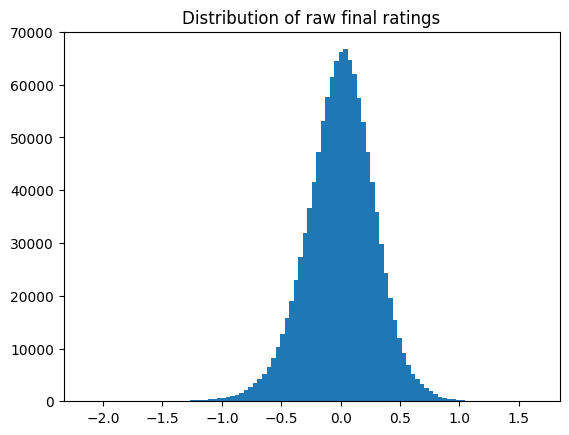

min: 0.5851185539053227
max: 5.488903510675363
mean: 3.8564711821080087
count_over_5: 3523
count_under_1: 17

min: 1.0
max: 5.0
mean: 3.8562365617633456


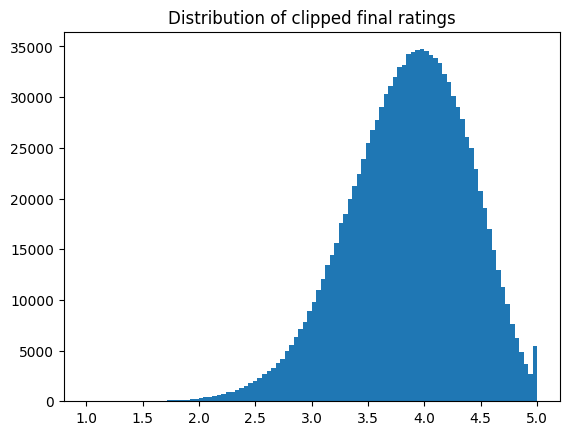

In [ ]:
from postprocess import postprocess
postprocess(LightGCNPlus, means, stds)